In [8]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
import soundfile
import subprocess
import os
import colorednoise as cn
from scipy.signal import butter, lfilter, filtfilt

def frequency_mask(filename, output_file=None, frequency_center=None, width=None):
    # Load the audio file
    audio, sample_rate = librosa.load(filename, sr=None)

    # Design a band-stop filter
    lowcut = frequency_center - width / 2
    highcut = frequency_center + width / 2
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    order = 4
    b, a = butter(order, [low, high], btype='bandstop')

    # Apply the filter to the audio
    masked_audio = filtfilt(b, a, audio)

    # Save the transformed audio file
    if output_file:
        sf.write(output_file, masked_audio, sample_rate)
    else:
        return masked_audio, sample_rate


input_folder = 'lt400'
output_folder = 'output_folder'
width_values = [ 200, 300]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_width in width_values:
    output_folder = os.path.join(output_folder, f'width{desired_width}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        frequency_mask(file, output_filename, 1000 , desired_width)

        

In [9]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)


import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, width):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), width])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "width"])
        writer.writerows(output)



#transcribe_files_to_tsv("lt400/", "lt400.tsv")
transcribe_files_to_tsv("width200/", os.path.join("width200", "width200.tsv"))
transcribe_files_to_tsv("width300/", os.path.join("width300", "width300.tsv"))

ORIGINAL_FOLDER = "lt400"


tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)




augmented_folder = "width200"
width10_path = Path("width200/width200.tsv")
width10 = read_tsv_file(width10_path)
output_width10 = Path("OUTPUT200width.tsv")

calculate_wer_pesq(tsv_data, width10, output_width10,200)


augmented_folder = "width300"
width20_path = Path("width300/width300.tsv")
width20 = read_tsv_file(width20_path)
output_width20 = Path("OUTPUT300width.tsv")

calculate_wer_pesq(tsv_data, width20, output_width20,300)



LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/HCLr.fst /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

lt400/common_voice_ca_31378986.wav  width200/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  width200/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101129.wav  width200/upc_ca_pau_101129.wav
lt400/upc_ca_pau_101059.wav  width200/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  width200/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  width200/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  width200/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  width200/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  width200/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  width200/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  width200/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  width200/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  width200/upc_ca_ona_100029.wav
lt400/common_voice_ca_30957869.wav  width200/common_voice_ca_30957869.wav
lt400/upc_ca_ona_100072.wav  width

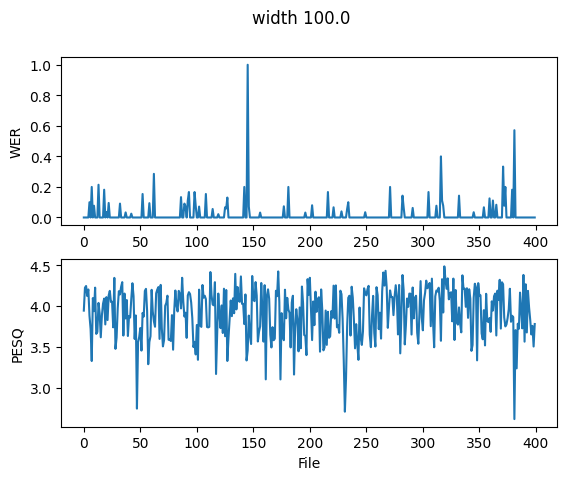

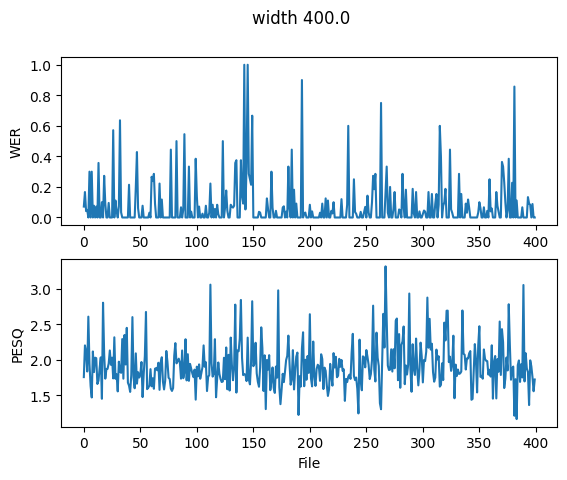

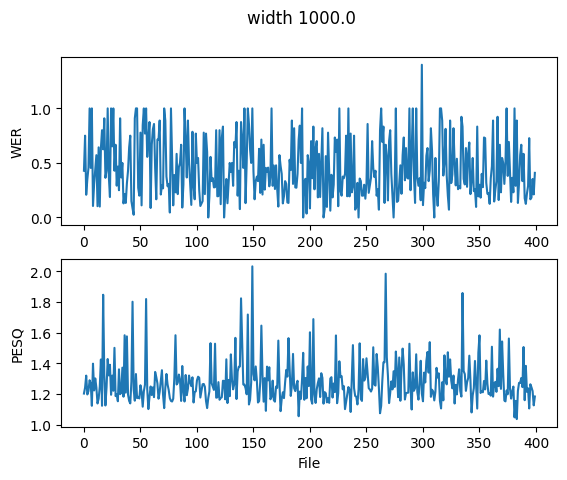

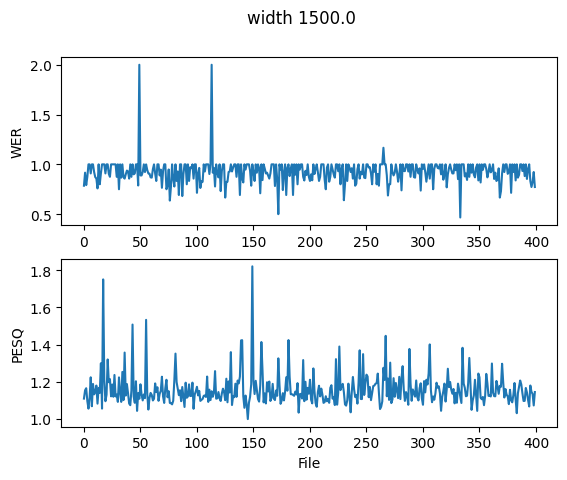

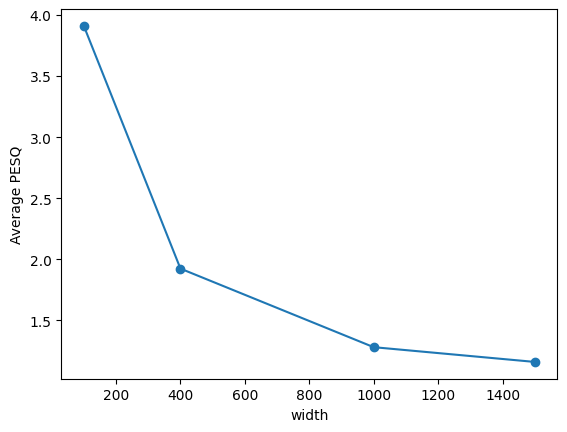

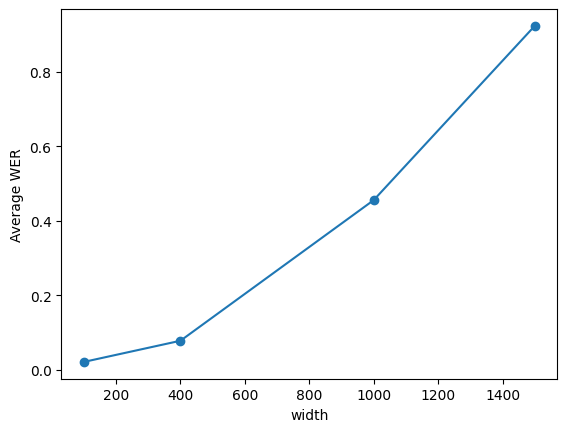

({1500.0: {'WER': 0.9241466183603945, 'PESQ': 1.1583882499999998}},
 {1500.0: {'WER': [0.7857142857142857,
    0.9166666666666666,
    0.7916666666666666,
    0.875,
    1.0,
    1.0,
    0.9090909090909091,
    1.0,
    1.0,
    0.9230769230769231,
    0.8717948717948718,
    0.8571428571428571,
    0.7586206896551724,
    1.0,
    0.8,
    0.9090909090909091,
    1.0,
    1.0,
    1.0,
    0.9090909090909091,
    1.0,
    1.0,
    0.9047619047619048,
    0.875,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.875,
    1.0,
    0.75,
    1.0,
    0.8666666666666667,
    1.0,
    0.8709677419354839,
    0.8571428571428571,
    0.9,
    0.9375,
    0.9285714285714286,
    0.8571428571428571,
    1.0,
    0.875,
    1.0,
    0.9,
    0.9090909090909091,
    1.0,
    1.0,
    0.7878787878787878,
    2.0,
    0.8888888888888888,
    0.8888888888888888,
    0.9230769230769231,
    1.0,
    0.9230769230769231,
    1.0,
    0.9444444444444444,
    0.9090909090909091,
    0.90625,
    0.8695

In [4]:


import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["width"] = [float(width) for width in data["width"]]


    # Group the data by width
    grouped_data = {}
    for width, wer, pesq in zip(data["width"], data["WER"], data["PESQ"]):
        if width not in grouped_data:
            grouped_data[width] = {"WER": [], "PESQ": []}
        grouped_data[width]["WER"].append(wer)
        grouped_data[width]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each width
    avg_data = {}
    for width, width_data in grouped_data.items():
        avg_wer = np.mean(width_data["WER"])
        avg_pesq = np.mean(width_data["PESQ"])
        avg_data[width] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT100width.tsv"),
    Path("OUTPUT400width.tsv"),
    Path("OUTPUT1000width.tsv"),
    Path("OUTPUT1500width.tsv")
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each width
    for width, width_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"width {width}")
        plt.subplot(2, 1, 1)
        plt.plot(width_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(width_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all widths
widths = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each width
    # (same as before)

# Plot the average WER data for all widths
widths = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all widths
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(widths, avg_pesqs, 'o-')
plt.xlabel("width")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(widths, avg_wers, 'o-')
plt.xlabel("width")
plt.ylabel("Average WER")
plt.show()


output_file_path2 = Path("OUTPUT100width.tsv")
output_file_path3 = Path("OUTPUT400width.tsv")
output_file_path4 = Path("OUTPUT1000width.tsv")
output_file_path5 = Path("OUTPUT1500width.tsv")



plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)



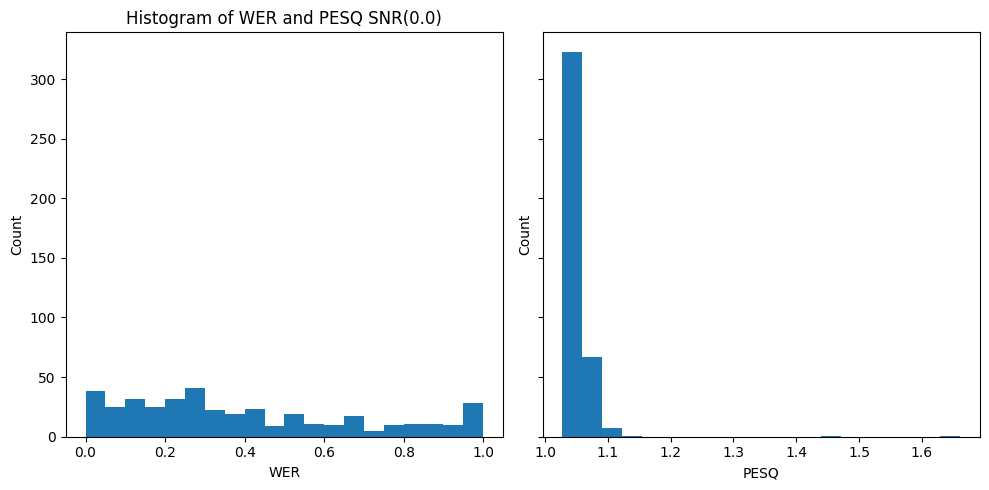

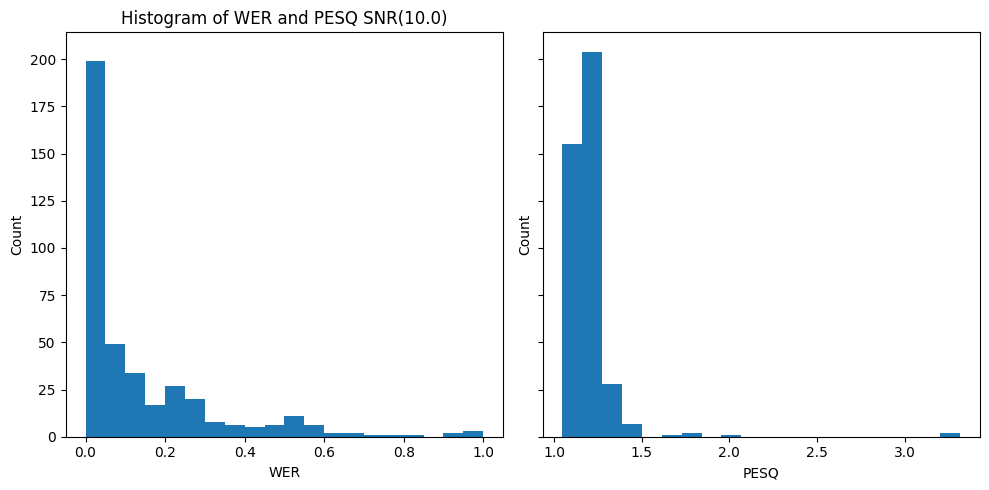

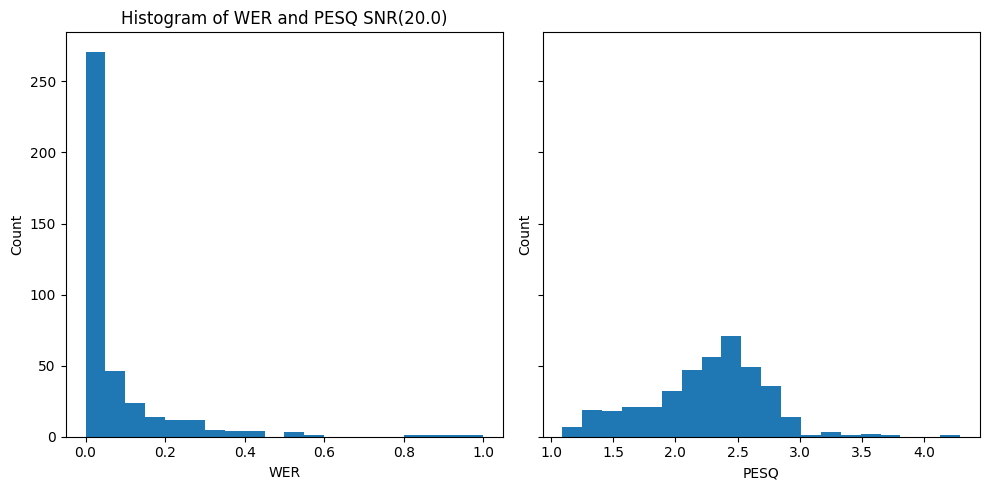

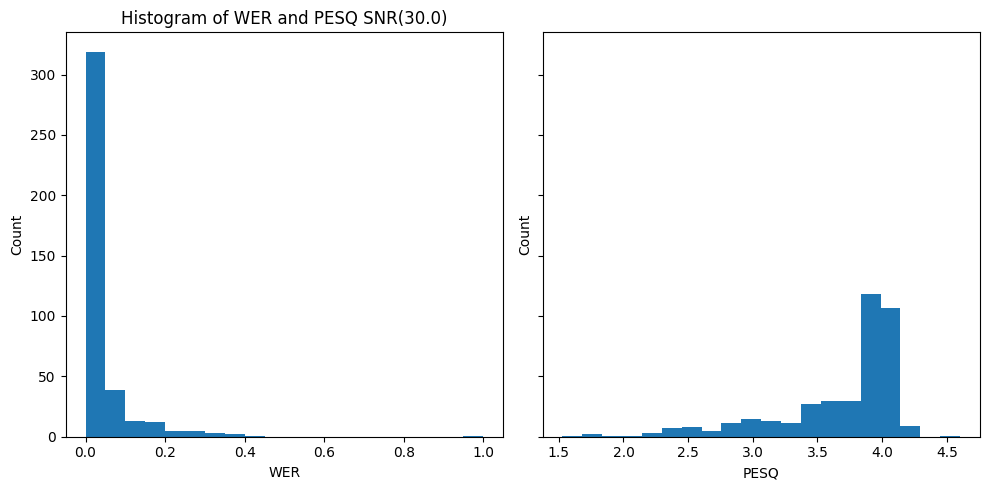

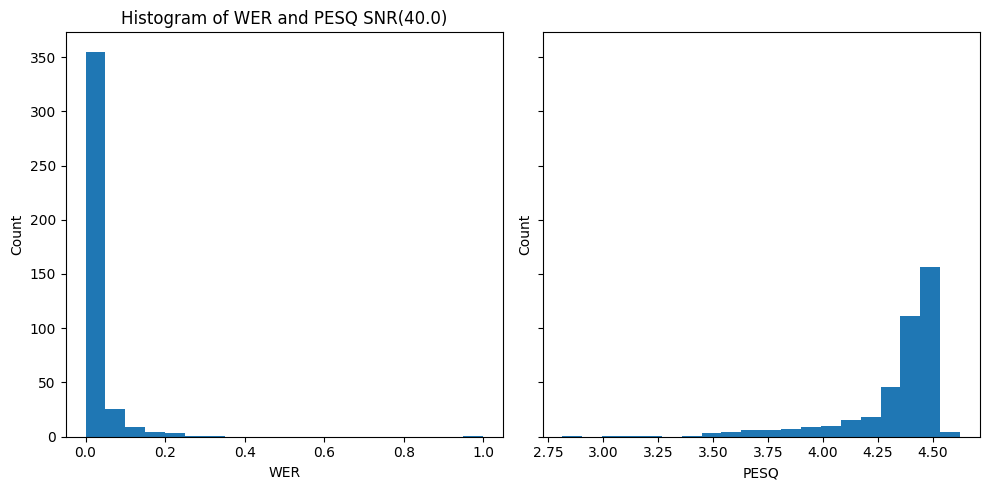

In [8]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [float(SNR) for SNR in data["SNR"]]


    # Group the data by SNR
    grouped_data = {}
    for SNR, wer, pesq in zip(data["SNR"], data["WER"], data["PESQ"]):
        if SNR not in grouped_data:
            grouped_data[SNR] = {"WER": [], "PESQ": []}
        grouped_data[SNR]["WER"].append(wer)
        grouped_data[SNR]["PESQ"].append(pesq)

    # Create subplots for each SNR level
    num_SNRs = len(grouped_data)
    if num_SNRs == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_SNRs, 2, figsize=(10, 10), sharey=True)

    for i, (SNR, SNR_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(SNR_data["WER"], range=(0, 1), bins=20)
        axs[i][1].hist(SNR_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_SNRs == 1:
            axs[i][0].set_title(F"Histogram of WER and PESQ SNR({SNR})")
        else:
            axs[i][0].set_title(f"Histogram of WER (SNR {SNR})")
            axs[i][1].set_title(f"Histogram of PESQ (SNR {SNR})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


output_file_path1 = Path("OUTPUT10width.tsv")
output_file_path2 = Path("OUTPUT100width.tsv")
output_file_path3 = Path("OUTPUT400width.tsv")
output_file_path4 = Path("OUTPUT1000width.tsv")
output_file_path5 = Path("OUTPUT1500width.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)


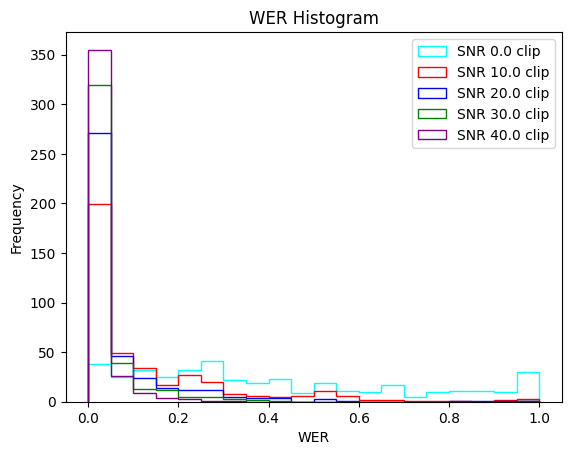

In [10]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["SNR"] = [float(SNR) for SNR in data["SNR"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)

    return data["SNR"], data["WER"]

# Define colors for each SNR value
SNR_colors = {10: 'cyan', 100: 'red', 400: 'blue', 1000: 'green', 1500: 'purple'}

output_file_paths = [
    Path("OUTPUT10width.tsv"),
    Path("OUTPUT100width.tsv"),
    Path("OUTPUT400width.tsv"),
    Path("OUTPUT1000width.tsv"),
    Path("OUTPUT1500width.tsv")
]

wer_data = {}
for output_file_path in output_file_paths:
    SNR, wer = plot_wer(output_file_path)
    for SNR_value, wer_value in zip(SNR, wer):
        if SNR_value not in wer_data:
            wer_data[SNR_value] = []
        wer_data[SNR_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for SNR_value, wer_values in wer_data.items():
    color = SNR_colors[SNR_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'SNR {SNR_value} clip')

#plt.ylim(0, 250)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


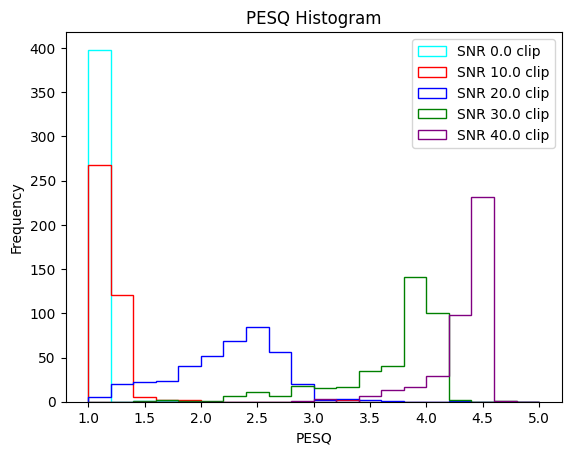

In [11]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by width
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["width"] = [float(width) for width in data["width"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["width"], data["PESQ"]

# Define colors for each width value
width_colors = {10: 'cyan', 100: 'red', 400: 'blue', 1000: 'green', 1500: 'purple'}

output_file_paths = [
    Path("OUTPUT10width.tsv"),
    Path("OUTPUT100width.tsv"),
    Path("OUTPUT400width.tsv"),
    Path("OUTPUT1000width.tsv"),
    Path("OUTPUT1500width.tsv")
]

pesq_data = {}
for output_file_path in output_file_paths:
    width, pesq = plot_pesq(output_file_path)
    for width_value, pesq_value in zip(width, pesq):
        if width_value not in pesq_data:
            pesq_data[width_value] = []
        pesq_data[width_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for width_value, pesq_values in pesq_data.items():
    color = width_colors[width_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'width {width_value} clip')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()


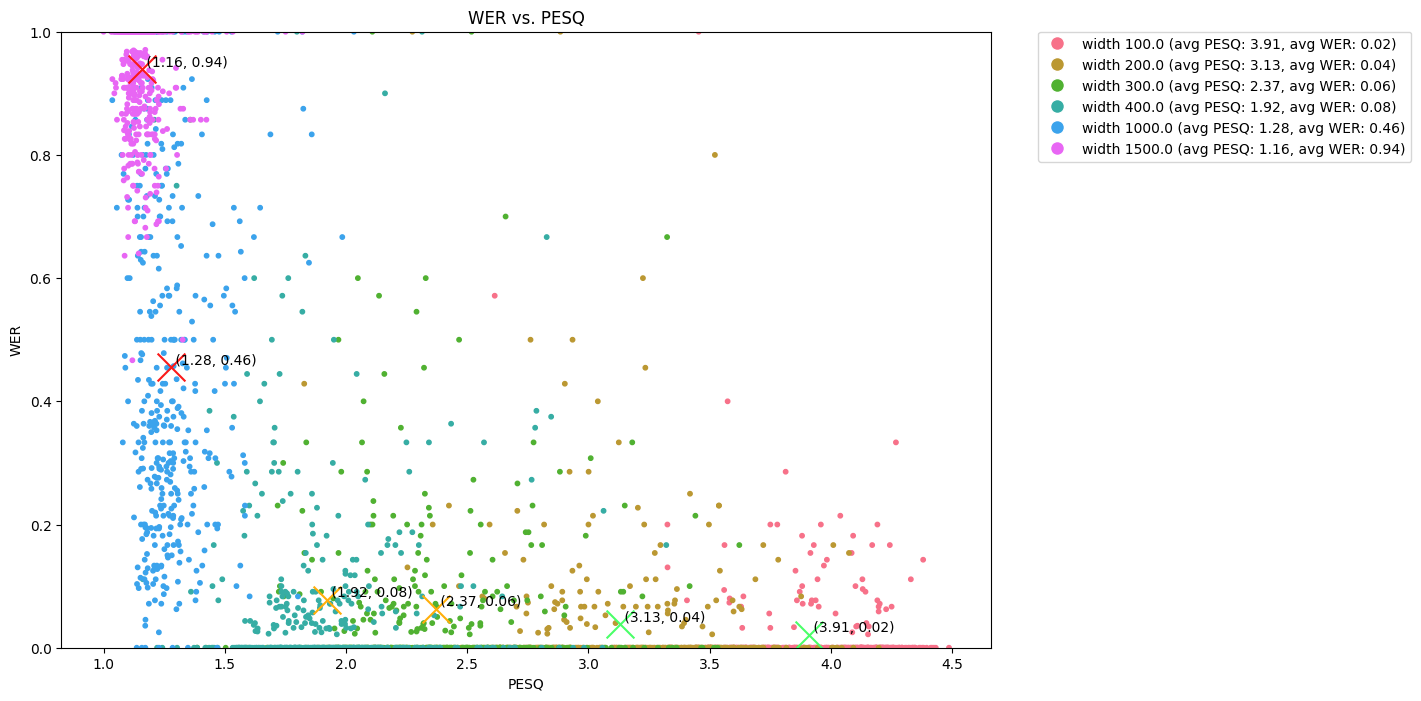

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)
            for line in tsv_file:
                width = float(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if width not in grouped_data:
                    grouped_data[width] = {'WER': [], 'PESQ': []}
                
                grouped_data[width]['WER'].append(wer) 
                grouped_data[width]['PESQ'].append(pesq)
    
    width_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(width_levels))
    width_colors = dict(zip(width_levels, rgb_values))

    X_colors = {
        100: '#4AFF68',
        200: '#4AFF68',
        300: '#FFAE0A',
        400: '#FFAE0A',
        1000: '#FA1919',
        1500: '#FA1919'
    }

    plt.figure(figsize=(12, 8))
    
    avg_values = []

    for width, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[width_colors[width]] * len(wer), label=f'width {width}', s=10, zorder=1)
        plt.scatter(avg_pesq, avg_wer, c=[X_colors[width]], marker='x', s=400, zorder=2)
        plt.text(avg_pesq, avg_wer, f' ({avg_pesq:.2f}, {avg_wer:.2f})', fontsize=10, verticalalignment='bottom', zorder=3)
        avg_values.append((width, avg_pesq, avg_wer))

    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    
    legend_elements = [
        plt.Line2D(
            [0], [0], marker='o', color='w', label=f'width {x[0]} (avg PESQ: {x[1]:.2f}, avg WER: {x[2]:.2f})', 
            markerfacecolor=width_colors[x[0]], markersize=10
        ) for x in avg_values
    ]

    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

# Define colors for each width value
width_colors = {0: 'cyan', 10: 'red', 20: 'blue', 30: 'green', 40: 'purple'}

output_file_paths = [
    Path("OUTPUT100width.tsv"),
    Path("OUTPUT200width.tsv"),
    Path("OUTPUT300width.tsv"),
    Path("OUTPUT400width.tsv"),
    Path("OUTPUT1000width.tsv"),
    Path("OUTPUT1500width.tsv")
]

plot_wer_pesq(output_file_paths)
